# Experimental analysis of minimum difference height levels

Based on `analyse_mindiff_level_heights.ipynb`.

The idea is that, for every MCS track point, there will be a height level that has the minimum difference from the movement velocity of the MCS. This is just a minimum in the squared difference of u and vel_x..., calculated in the remakefile loaded below. The level is saved for each point - here, I've got code to turn this into a figure. I've borrowed code from `np.histogramdd` to get indices of each of the lon/lat points to use to store the level data. Then I make a 3D array (hist.max(), nlon, nlat) to store the level data, and match it up using the indices. Finally plot mean/stdon a map.

I am calling the resulting level a "steering level".

Data was produced for 2019 only at the moment. Input data limited to level >=77, see analysis in `analyse_mindiff_level_heights.ipynb` for why - essentially the histogram of of model levels was bimodal, with a minimum at level 77. I am only interested in lower values, so find the mindiff level in levels 77-137 for further analysis. Note, this is different to performing analysis in levels >=38 then discarding values, which is what I did previously.

* 23/5/22: Initial work.
* 31/5/22: Add in analysis looking at mean wind profiles over regions.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import stats
import xarray as xr

from remake import load_remake
%matplotlib notebook

In [2]:
tep = load_remake('../remakefiles/track_era5_propagation_corr.py')

# There are 365 for 2019 of these saved on JASMIN currently.
linked_data_paths = [t.outputs['track_era5_linked_data'] for t in tep.TrackERA5LinkData.tasks.filter(year=2019)]

ds = xr.open_mfdataset(linked_data_paths, concat_dim='index', combine='nested')
ds['index'] = np.arange(len(ds['index']))

ds

<xarray.Dataset>
Dimensions:             (index: 541495, level: 4)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 541491 541492 541493 541494
  * level               (level) int32 77 97 117 137
Data variables:
    point_time          (index) datetime64[ns] dask.array<chunksize=(1169,), meta=np.ndarray>
    meanlon             (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>
    meanlat             (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>
    track_point_era5_u  (level, index) float32 dask.array<chunksize=(4, 1169), meta=np.ndarray>
    track_point_era5_v  (level, index) float32 dask.array<chunksize=(4, 1169), meta=np.ndarray>
    track_point_vel_x   (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>
    track_point_vel_y   (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>
    min_diff_level      (index) int32 dask.array<chunksize=(1169,), meta=np.ndarray>
    min_sq_diff         (index) float32 dask.array<chunksize=(1169,), meta=np.ndarray>

In [3]:
lonlat = np.vstack([ds.meanlon.values, ds.meanlat.values]).T

lonlat.shape

(541495, 2)

In [4]:
edges = (np.arange(-180, 184, 4), np.arange(-60, 64, 4))
nbins = np.array([len(e) - 1 for e in edges])

In [5]:
# Code below borrows heavily from np.histogramdd

# Calc. the two indexes (lon, lat) by digitizing each value based on bins.
# The -1 puts the indices in the correct place for 2D array access.
idx = tuple(
    np.digitize(lonlat[:, i], edges[i]) - 1
    for i in range(2)
)

In [6]:
# Flatten the two indices into one (for a flattened array)
flat_idx = np.ravel_multi_index(idx, nbins)

# Calc the histogram values.
hist = np.bincount(flat_idx, minlength=nbins.prod())

# Reshape back to 2D.
hist = hist.reshape(nbins)
hist

array([[ 59,  49,  36, ...,  43,  18,  19],
       [ 58,  63,  71, ...,  45,  12,   7],
       [ 41,  53,  63, ...,  58,  37,   9],
       ...,
       [ 40,  73, 119, ...,  62,  18,  14],
       [ 74,  94, 105, ...,  47,  40,  12],
       [ 74,  55,  83, ...,  55,  20,  13]])

<IPython.core.display.Javascript object>


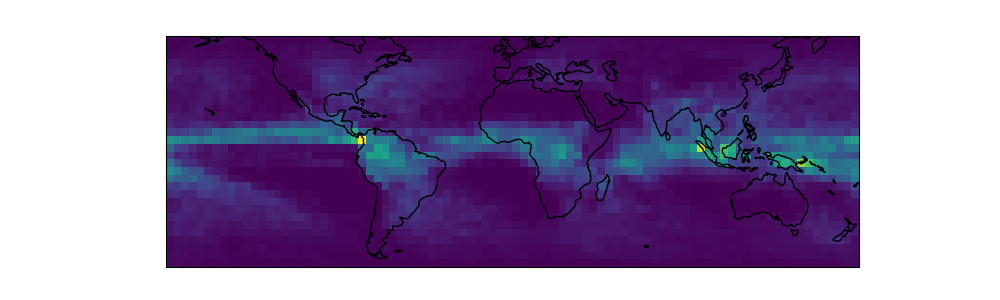

In [7]:
# Sanity check. Plot MCS hist.
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 3)
ax.imshow(hist.T, origin='lower', extent=(-180, 180, -60, 60))
ax.coastlines();

In [8]:
hist.max()

2247

In [9]:
hist.shape

(90, 30)

In [10]:
# Construct a 3D np.nan array which will hold the values of mindiff height levels.
mindiff_height_level = np.full((2247, 90, 30), np.nan)

In [11]:
# Find unique flat/2D indices.
uniq_flat_idx = np.unique(flat_idx)
uniq_idx = np.array(np.unravel_index(uniq_flat_idx, nbins))

In [12]:
# Grab the min_diff level data (same shape as uniq_flat_idx)
min_diff_level = ds.min_diff_level.values

In [13]:
# Pull out the min_diff level data for each unique flat index.
for ufi, ui in zip(uniq_flat_idx, uniq_idx.T):
    # Use data from hist to get correct number of levels to store.
    # Use ui[0], ui[1] to index into lon/lat coords.
    # Mask out values using flat_idx == ufi for each unique index.
    mindiff_height_level[:hist[ui[0], ui[1]], ui[0], ui[1]] = min_diff_level[flat_idx == ufi]

In [14]:
np.nanmean(mindiff_height_level)

105.58422700117268

<IPython.core.display.Javascript object>


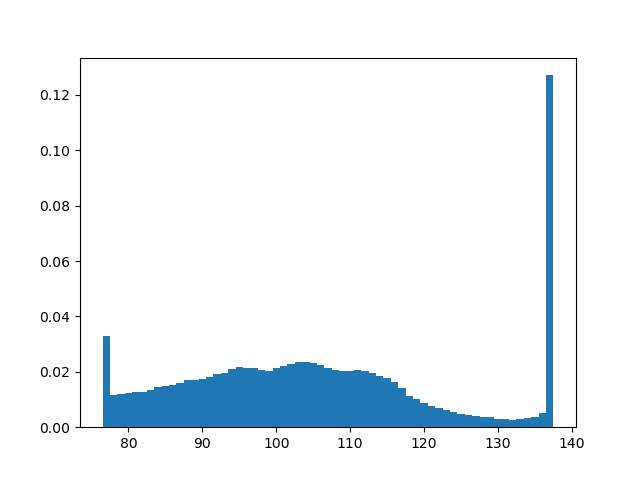

In [15]:
plt.figure()
plt.hist(min_diff_level, bins=np.arange(76, 138) + 0.5, density=True);

Large spike in values at 137 (surf) means that results probably not best analysed using mean, as this will drag down most values. Try using median as well. Also, perhaps worth filtering out this value. Spike at level 77 as well - this is the highest model analysis height used. 12.5% of values fall in this bin. Spike not so large - filter out? Spike at 77 is only 3% of values.

In [16]:
def plot_min_diff_levels(name, func, mindiff_height_level, reduced_levels=False):
    data = func(mindiff_height_level, axis=0).T
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches(10, 3)
    if name == 'std':
        levels = [0, 10, 20, 30, 40, 50]
    elif name in ['median', 'mean', 'mode']:
        levels = [76, 80, 90, 100, 110, 120, 130, 137]
        if reduced_levels:
            levels = levels[3:]
    else:
        levels = np.linspace(0, data.max(), 20)    
    norm = colors.BoundaryNorm(levels, ncolors=256)
    cmap = plt.cm.Spectral.copy()
    cmap.set_bad('grey', 1.)
    im = ax.imshow(data, origin='lower', 
                   norm=norm, cmap=cmap,
                   extent=(-180, 180, -60, 60))
    ax.coastlines()
    cbar = plt.colorbar(im)
    if name in ['mean', 'median', 'mode']:
        # Taken roughly from here: https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height?preview=/158636068/226495690/levels_137.png
        # N.B. these are ocean/zero orog. values.
        level_press_map = {
            76: 210,
            80: 260,
            90: 420,
            100: 600,
            110: 800,
            # Hard to read 120/130 off image.
            137: 1000,
        }
        def fmt_label(k, v):
            if v:
                return f'{k} - {v} hPa'
            else:
                return k
        labels = [fmt_label(k, level_press_map.get(k, None)) for k in levels]
        cbar.ax.set_yticks(levels, labels=labels)
        cbar.ax.invert_yaxis()
    ax.set_title(f'{name} level of minimum difference')
    plt.show()

/tmp/ipykernel_28711/1062185901.py:2: RuntimeWarning: Mean of empty slice
  data = func(mindiff_height_level, axis=0).T


<IPython.core.display.Javascript object>


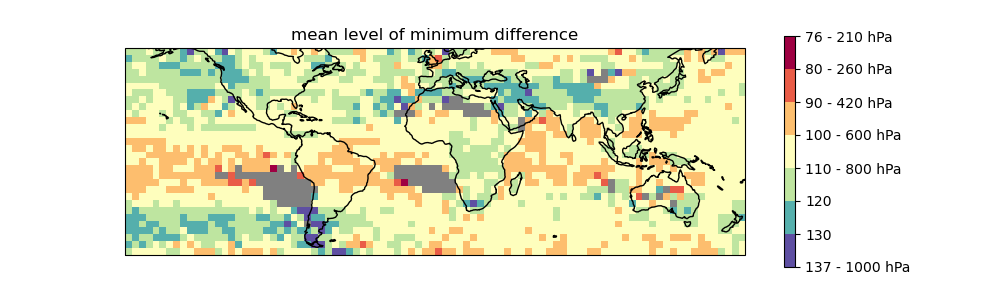

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


<IPython.core.display.Javascript object>


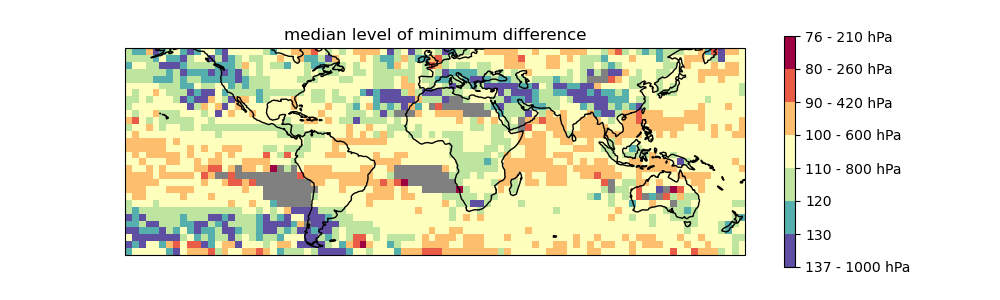

In [17]:
plot_min_diff_levels('mean', np.nanmean, mindiff_height_level)
plot_min_diff_levels('median', np.nanmedian, mindiff_height_level)

/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<IPython.core.display.Javascript object>


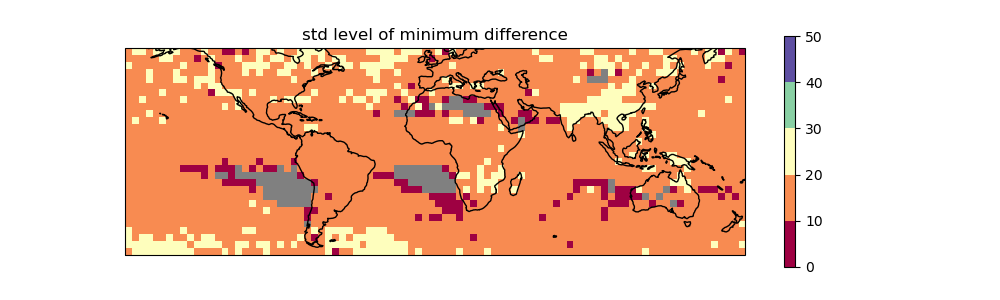

In [18]:
plot_min_diff_levels('std', np.nanstd, mindiff_height_level)

Standard deviation is generally 20-30 model level (eq. ocean), 20-40 levels (land/non-eq ocean). Low values probably just indicate not enough data (could mask out low numbers of MCSs...). 

Interesting line running just N of eq. through Pacific. Don't think this is an artefact. Not obvious in mean. 

<IPython.core.display.Javascript object>


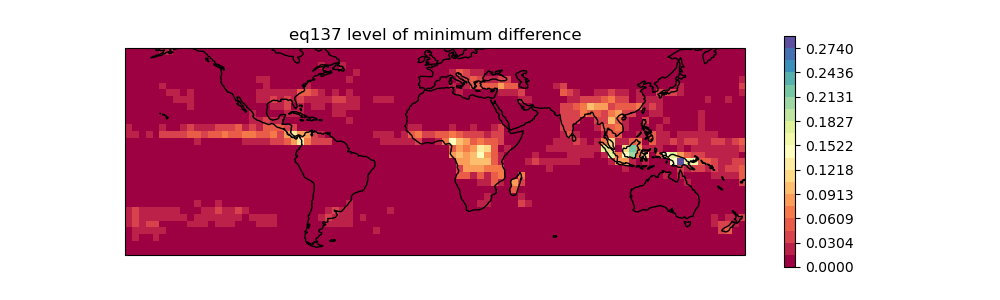

In [19]:
def eq137(mindiff_height_level, axis):
    return np.nanmean(mindiff_height_level == 137, axis=axis)

plot_min_diff_levels('eq137', eq137, mindiff_height_level)

In [20]:
np.nanmean(mindiff_height_level == 137, axis=0).max()

0.2892745883400089

## Regional analysis

Pick out 8 regions based on where MCS activity is, where looks interesting for steering level.

<IPython.core.display.Javascript object>


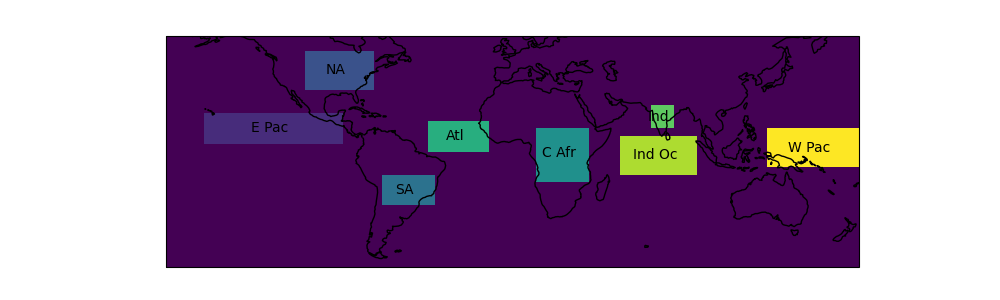

In [21]:
from itertools import product
lons, lats = edges
def get_reg(minx, maxx, miny, maxy):
    idx = np.array(list(product(np.where((lons >= minx) & (lons <= maxx))[0], np.where((lats >= miny) & (lats <= maxy))[0]))).T
    return tuple([idx[0], idx[1]])

reg = np.zeros_like(hist)

rvals = [
    ('E Pac', (-160, -92, 4, 16)),
    ('NA', (-108, -76, 32, 48)),
    ('SA', (-68, -44, -28, -16)),
    ('C Afr', (12, 36, -16, 10)),
    ('Atl', (-44, -16, 0, 12)),
    ('Ind', (72, 80, 12, 20)),
    ('Ind Oc', (56, 92, -12, 4)),
    ('W Pac', (132, 176, -8, 8)),
]
for i, rval in enumerate(rvals):
    reg[get_reg(*rval[1])] = i + 1
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 3)
for i, rval in enumerate(rvals):
    meanx, meany = np.mean(rval[1][:2]), np.mean(rval[1][2:])
    ax.annotate(xy=(meanx, meany), text=rval[0], ha='center')
ax.imshow(reg.T, origin='lower', extent=(-180, 180, -60, 60))
ax.coastlines();

<IPython.core.display.Javascript object>


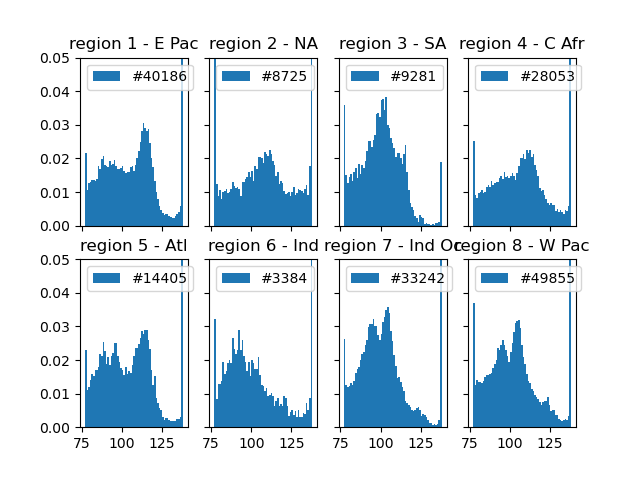

In [22]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

for i, (rval, ax) in enumerate(zip(rvals, axes.flatten())):
    d = mindiff_height_level[:, reg == i + 1]
    ax.hist(d[~np.isnan(d)], bins=np.arange(76, 138) + 1, density=True, label=f'#{(~np.isnan(d)).sum()}')
    ax.set_title(f'region {i + 1} - {rval[0]}')
    ax.set_ylim((0, 0.05))
    ax.legend(loc='upper left')


Note, spikes in histograms at 77, 137. I do not want these to affect all of the statistics, so filter these out.

## Redo analysis but only for levels > 77 and < 137

In [23]:
# Grab the min_diff level data (same shape as uniq_flat_idx)
min_diff_level = ds.min_diff_level.values

In [24]:
level_mask = (min_diff_level > 77) & (min_diff_level < 137)

In [25]:
# Find unique flat/2D indices.
uniq_flat_idx = np.unique(flat_idx[level_mask])
uniq_idx = np.array(np.unravel_index(uniq_flat_idx, nbins))

In [26]:
# Grab the min_diff level data (same shape as uniq_flat_idx)
min_diff_level = min_diff_level[level_mask]

In [27]:
# Construct a 3D np.nan array which will hold the values of mindiff height levels.
mindiff_height_level = np.full((2247, 90, 30), np.nan)

In [28]:
# Pull out the min_diff level data for each unique flat index.
for ufi, ui in zip(uniq_flat_idx, uniq_idx.T):
    # Use data from hist to get correct number of levels to store.
    # Use ui[0], ui[1] to index into lon/lat coords.
    # Mask out values using flat_idx == ufi for each unique index.
    mask = flat_idx[level_mask] == ufi
    mindiff_height_level[:mask.sum(), ui[0], ui[1]] = min_diff_level[mask]

/tmp/ipykernel_28711/1062185901.py:2: RuntimeWarning: Mean of empty slice
  data = func(mindiff_height_level, axis=0).T


<IPython.core.display.Javascript object>


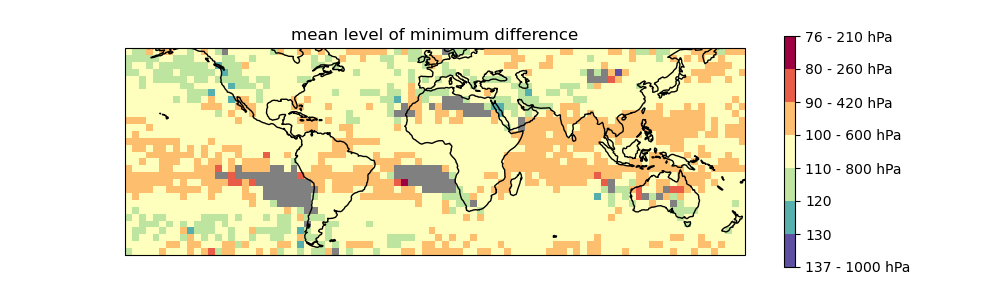

<IPython.core.display.Javascript object>


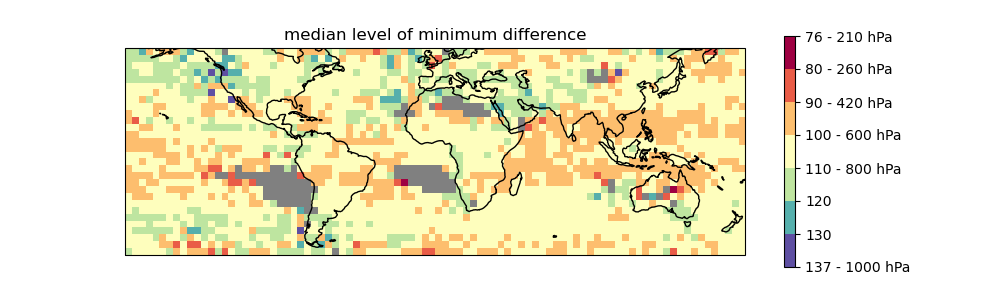

In [29]:
plot_min_diff_levels('mean', np.nanmean, mindiff_height_level)
plot_min_diff_levels('median', np.nanmedian, mindiff_height_level)

I'm now reasonably happy with analysis. Above, mean and median give very similar spatial patterns of steering-level winds. Generally, winds are between level 120 - 90 (roughly 860 - 420 hPa). Levels are higher over the Indian Ocean, India, BoB, W Pacific. However, the most striking differences occur in the mode of the values (see regional analysis below and next fig.).

<IPython.core.display.Javascript object>


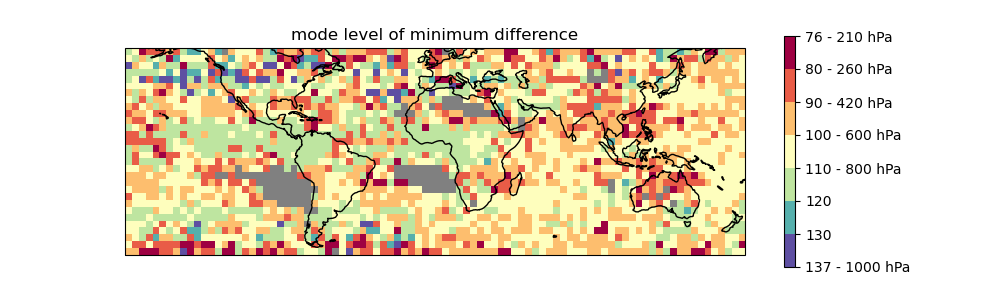

In [30]:
def mode(data, axis):
    """Handles 3D array with nans accounted for."""
    ret = np.full(data.shape[1:], np.nan)
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            m, counts = stats.mode(data[~np.isnan(data[:, i, j]), i, j])
            if len(m):
                ret[i, j] = m[0]
    return ret

plot_min_diff_levels('mode', mode, mindiff_height_level)

The mode is more noisy, but it also better captures some of the differences between regions. There are now substantial areas where the steering-level winds are below 800 hPa - over eq. E Pac, Columbia, Atl (mixed) and W Africa. NE India has higher s-l winds (420 - 260 hPa). NA has lower s-l winds - almost surface level for some grid points. 

<IPython.core.display.Javascript object>


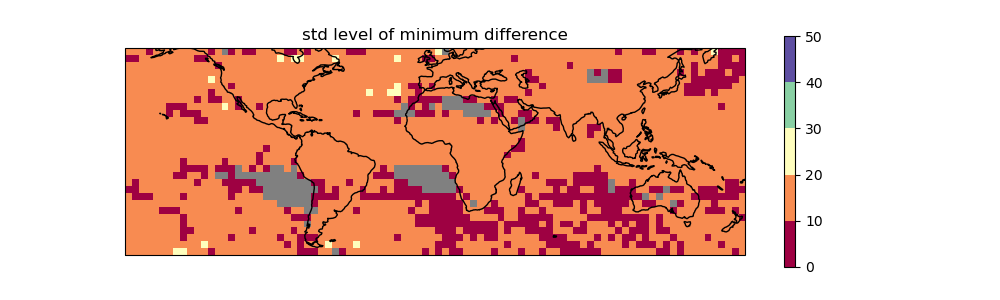

In [31]:
plot_min_diff_levels('std', np.nanstd, mindiff_height_level)

<IPython.core.display.Javascript object>


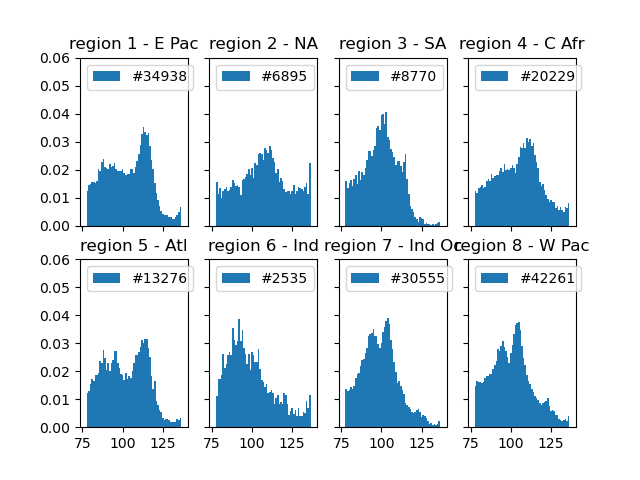

In [32]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

for i, (rval, ax) in enumerate(zip(rvals, axes.flatten())):
    d = mindiff_height_level[:, reg == i + 1]
    ax.hist(d[~np.isnan(d)], bins=np.arange(76, 138) + 0.5, density=True, label=f'#{(~np.isnan(d)).sum()}')
    ax.set_title(f'region {i + 1} - {rval[0]}')
    ax.set_ylim((0, 0.06))
    ax.legend(loc='upper left')

Several regions show bimodal structure - E Pac, Atl, Ind Oc and W Pac. N.B. these are generally larger regions. The lowest modal height is E Pac and Atl, which is consistent with the mode figure above. India has the highest height at around level 93 (~420 hPa). The different modes account for the fact that the global histogram appears to have 3 main modes.

## Follow-on work

What causes the spikes at level 137? 77? Do these values have low MCS movement speeds?

In [33]:
# Grab the min_diff level data (same shape as uniq_flat_idx)
min_diff_level = ds.min_diff_level.values
vel_x = ds.track_point_vel_x
vel_y = ds.track_point_vel_y

In [34]:
speed = np.sqrt(vel_x**2 + vel_y**2)

<IPython.core.display.Javascript object>


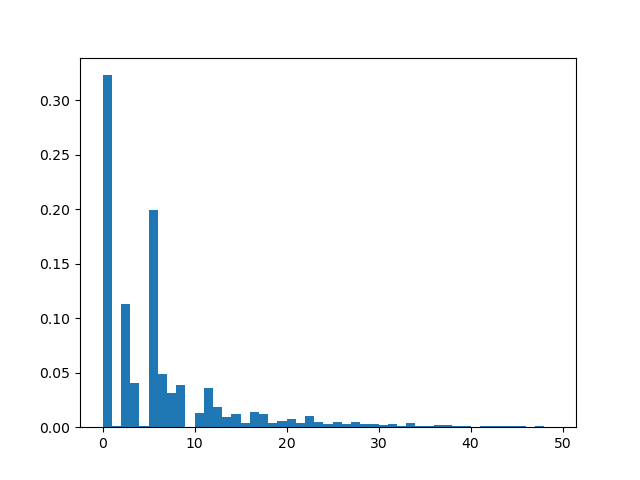

In [35]:
plt.figure()
plt.hist(speed, bins=np.arange(0, 50), density=True);

<IPython.core.display.Javascript object>


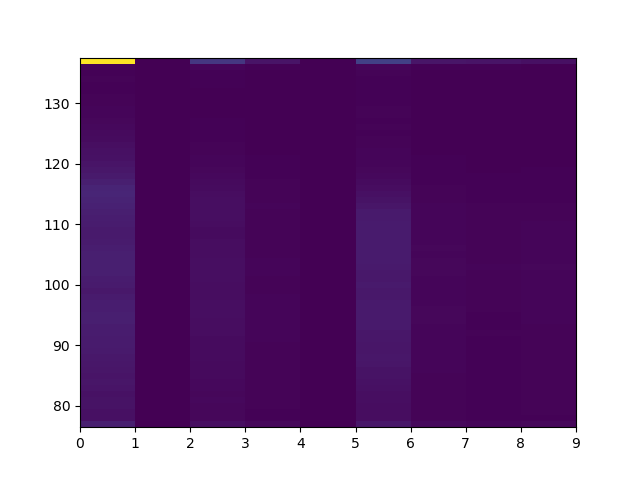

In [36]:
plt.figure()
plt.hist2d(speed, min_diff_level, bins=(np.arange(10), np.arange(76, 138) + 0.5));

<IPython.core.display.Javascript object>


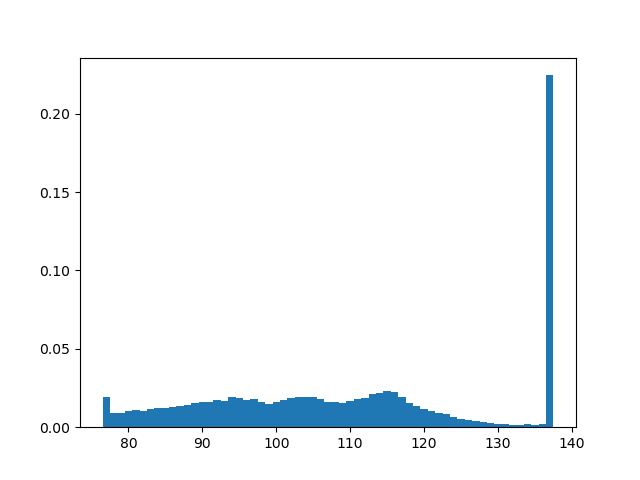

In [37]:
plt.figure()
plt.hist(min_diff_level[speed < 1], bins=np.arange(76, 138) + 0.5, density=True);

<IPython.core.display.Javascript object>


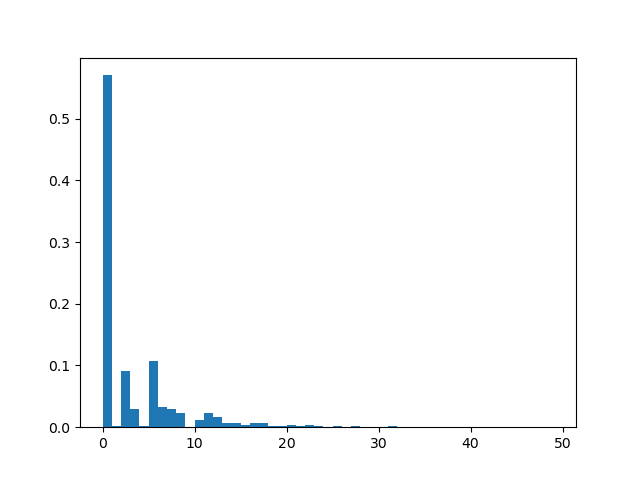

In [38]:
plt.figure()
plt.hist(speed[min_diff_level == 137], bins=np.arange(50), density=True);

Both these histograms show an increase in the fraction of 137/low speeds, conditional on the other. E.g. p(<1) = 32%, p(s<1|l=137) = 56%. p(l=137) = 12.5%, p(l=137|s<1) = 22%. Evidence in both cases that the spike in low height l=137 cases is given by stationary MCSs.

## Plot mean vertical profiles of wind for given regions.

In [42]:
profiles = []

for rval in rvals:
    print(rval[0])
    extent = rval[1]
    reg_mask = ((ds.meanlon > extent[0]) & (ds.meanlon < extent[1]) & (ds.meanlat > extent[2]) & (ds.meanlat < extent[3])).values
    u_profile = ds.track_point_era5_u.isel(index=reg_mask).mean(dim='index').values
    v_profile = ds.track_point_era5_v.isel(index=reg_mask).mean(dim='index').values
    profiles.append((u_profile, v_profile))

E Pac
NA
SA
C Afr
Atl
Ind
Ind Oc
W Pac


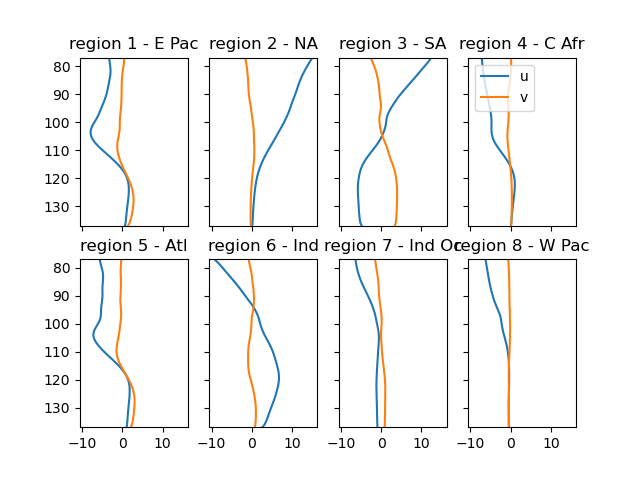

In [43]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)

for i, (rval, profile, ax) in enumerate(zip(rvals, profiles, axes.flatten())):
    u_profile, v_profile = profile
    ax.plot(u_profile, ds.level, label='u')
    ax.plot(v_profile, ds.level, label='v')
    ax.set_ylim((137, 77))
    ax.set_title(f'region {i + 1} - {rval[0]}')
    if i == 3:
        ax.legend(loc='upper left')

Interesting that only India shows much in the way of LLS. 110 is about 800 hPa. AND, India has a nominal steering level of around 90 (and that is where u=0, coincidence?) or 420 hPa. Now, this is for all points over the lifetime of an MCS, not just those close to the beginning of its tracking, so perhaps if I limited analysis to there I would see stronger shear below say 110. Also, little sign of any features that could explain the bimodal structure of the histograms in each region.